In [1]:
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [2]:
# Load the two NIfTI images
T1_path = 'data/T1.nii'
T2_path = 'data/T2_FLAIR.nii'
label_path = 'data/Labels.nii'

### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [3]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

Iteration:  0  --- Log Likelihood:  2.7547898669682533  --- Time (s):  0.09039688110351562


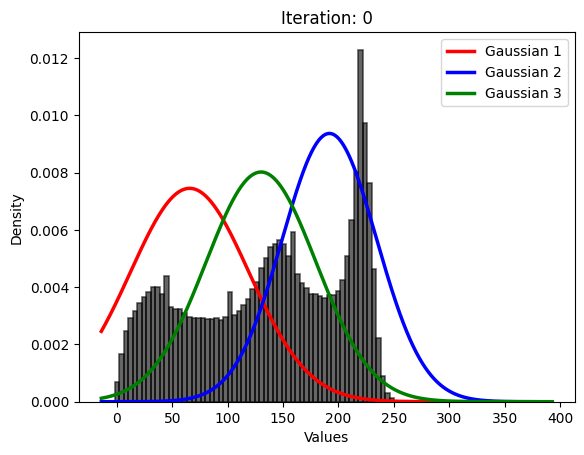

Iteration:  1  --- Log Likelihood:  3.030204471090128  --- Time (s):  0.09316706657409668
Iteration:  2  --- Log Likelihood:  3.1699814598776785  --- Time (s):  0.08954596519470215
Iteration:  3  --- Log Likelihood:  3.2142439554574227  --- Time (s):  0.0838007926940918
Iteration:  4  --- Log Likelihood:  3.22767069614034  --- Time (s):  0.08523297309875488
Iteration:  5  --- Log Likelihood:  3.2323360135049826  --- Time (s):  0.0798349380493164
Iteration:  6  --- Log Likelihood:  3.2347396544009714  --- Time (s):  0.08286690711975098
Iteration:  7  --- Log Likelihood:  3.2368252102942736  --- Time (s):  0.08511829376220703
Iteration:  8  --- Log Likelihood:  3.2392570624236408  --- Time (s):  0.08379292488098145
Iteration:  9  --- Log Likelihood:  3.2423501014454548  --- Time (s):  0.08091902732849121
Iteration:  10  --- Log Likelihood:  3.246347775464596  --- Time (s):  0.0855860710144043
Iteration:  11  --- Log Likelihood:  3.2515221910610372  --- Time (s):  0.08379507064819336
Iter

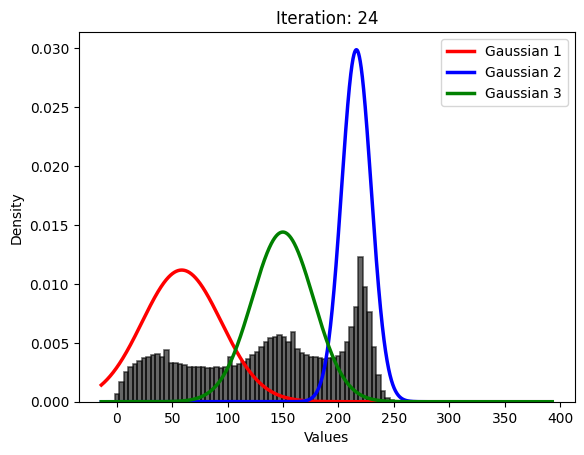

In [8]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=25, type='kmeans', plot_step=25, save_path='results/', show_plot=True, stop_criterion=1e-4)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [9]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [10]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == 1)
class2_idx = np.where(segmented_image == 2)
class3_idx = np.where(segmented_image == 3)
segmented_image[class1_idx] = sorted_mean_indices[0]
segmented_image[class2_idx] = sorted_mean_indices[1]
segmented_image[class3_idx] = sorted_mean_indices[2]

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, 'results/segmented_brain.nii')

print("Segmented brain image saved as 'results/segmented_brain.nii'")

Segmented brain image saved as 'results/segmented_brain.nii'


## Evaluation

In [11]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, 'results/segmented_brain.nii')    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.9054479456770035, 2: 0.8160248860973318, 3: 0.867292277310859}
Average Dice Score:  0.8629217030283981
